<a href="https://colab.research.google.com/github/sandeeprockstar/Pose_Estimation/blob/master/RP_Group6_Pytroch_code_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch implementation - Single Density 



This google colab document contains the Pytorch implementation of the single density model proposed by Prokudin, S. All codeblocks have a short description of its main function is. For an elaborate explanation please have a look at our blogpost: https://sandeeprockstar.github.io/Pose_Estimation/

Authors: \\
Seger Tak 4975154 \\
Sandeep Patil 4861213

#### Setting up the connection between the relevant folder in Google Drive and Google Colab
Enter your own path if its named differently (most probably!)

In [44]:
######################### Setup the right directory #####################
import os
from google.colab import drive
drive.mount("/content/drive")
os.chdir('/content/drive/My Drive/Deep Learning/deep_direct_stat-master')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing all required modules and datasets to run the model

In [0]:
######################## Required modules ###########################
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils import data
import torchvision
import torchvision.transforms as TF
from torchsummary import summary
from scipy.stats import sem

import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import math

# importing the datasets
from datasets import pascal3d
from datasets import caviar
from datasets import towncentre

# The support functions are usually imported from a seperate file; support_functions.py

# from support_functions import pdf
# from support_functions import cosine_loss_py, von_mises_neg_log_likelihood_py
# from support_functions import von_mises_log_likelihood_py
# from support_functions import rad2bit_py, deg2bit_py, deg2bit, rad2deg, bit2deg_py, deg2rad
# from support_functions import maad_from_deg_py

#### Running the support functions
In order to make the overview as clear as possible all code has been put into one notebook, including the support functions.

In [0]:
##################### LOSS FUNCTIONS ################################
def cosine_loss_py(y_target, y_pred):
    loss = 1 - torch.sum(torch.mul(y_target, y_pred), dim=1)
    mean_loss = torch.mean(loss)
    return mean_loss

def von_mises_neg_log_likelihood_py(y_true, y_pred):
    '''
    :param y_true : array with ground truth angle in biternion representation (cos, sin) of shape [n_samples, 1]
    :param y_pred : array with predicted mean angle (cos, sin) and kappa of shape [n_samples, 3]
    :return: mean negative log likelihood
    '''
    mu_pred = y_pred[:, 0:2]
    kappa_pred = y_pred[:, 2:]
    return -torch.mean(von_mises_log_likelihood_py(y_true, mu_pred, kappa_pred, input_type='biternion'))

# Conversion of von_mises_log_likelihood_tf
def von_mises_log_likelihood_py(y_true, mu_pred, kappa_pred, input_type='biternion'):
    '''
    Compute log-likelihood given data samples and predicted Von-Mises model parameters
    :param y_true: true values of an angle in biternion (cos, sin) representation
    :param mu_pred: predicted mean values of an angle in biternion (cos, sin) representation
    :param kappa_pred: predicted kappa (inverse variance) values of an angle in biternion (cos, sin) representation
    :param radian_input:
    :return:
    log_likelihood
    '''
    if input_type == 'degree':
        scaler = 0.0174533
        cosin_dist = torch.cos(scaler * (y_true - mu_pred))
    elif input_type == 'radian':
        cosin_dist = torch.cos(y_true - mu_pred)
    elif input_type == 'biternion':
        cosin_dist = torch.reshape(torch.sum(torch.mul(y_true, mu_pred), axis=1), [-1, 1])
    log_likelihood = kappa_pred.to(device) * cosin_dist - \
                     torch.log(2 * torch.tensor([math.pi]).to(device)) - log_bessel_approx_py(kappa_pred.to(device)) #torch.log(2 * torch.tensor([math.pi])) - log_bessel_approx_py(kappa_pred) 
    return torch.reshape(log_likelihood, [-1, 1])

# Conversion of log_bess_approx_tf
def log_bessel_approx_py(x):
    x = torch.reshape(x, [-1, 1])

    def _log_bessel_approx_0(x):
        bessel_taylor_coefs = torch.tensor([1.00000000e+00, 2.50000000e-01, 1.56250000e-02,
                                          4.34027778e-04, 6.78168403e-06]).to(device)
        m = bessel_taylor_coefs.shape[0]
        deg = torch.reshape(torch.arange(0, m, 1)*2, [1, -1])
        n_rows = x.size(0)
        x_tiled = x.repeat(1,m)
        deg_tiled = deg.repeat(n_rows,1)
        deg_reshape = torch.reshape(bessel_taylor_coefs[0:m],[1,m])
        coef_tiled = deg_reshape.repeat(n_rows,1)
        deg_tiled = deg_tiled.type(torch.FloatTensor).to(device)
        val = torch.log(torch.sum(torch.pow(x_tiled, deg_tiled)*coef_tiled, axis=1))
        return torch.reshape(val, [-1, 1])

    def _log_bessel_approx_large(x):
        return x - 0.5*torch.log(2*torch.tensor([math.pi]).to(device)*x)          

    res = torch.where(x > 5.0, _log_bessel_approx_large(x), _log_bessel_approx_0(x))

    return res

##################### ANGLE CONVERSION ################################

def rad2bit_py(angles_rad):
    """ radians to biternion ([cos, sin])
    """
    return torch.tensor([torch.cos(angles_rad), torch.sin(angles_rad)]).to(device).T 

def deg2bit(angles_deg):
    """ degrees to biternion ([cos, sin])
    """
    angles_rad = np.deg2rad(angles_deg)
    return np.array([np.cos(angles_rad), np.sin(angles_rad)]).T

def deg2bit_py(angles_deg):
    """ degrees to biternion ([cos, sin])
    """
    angles_rad = angles_deg * torch.tensor([math.pi]).to(device) / 180              
    print(angles_rad.shape)
    print(torch.cos(angles_rad).shape)
    print(torch.tensor([torch.cos(angles_rad),torch.sin(angles_rad)]).shape)
    return torch.tensor([torch.cos(angles_rad),torch.sin(angles_rad)]).to(device).T 

def rad2deg(angle_rad):
    return angle_rad * 180 / torch.tensor([math.pi]).to(device)

def bit2deg_py(angles_bit):
    """ biternion ([cos, sin]) ->  degrees
    """
    return (rad2deg(torch.atan2(angles_bit[:,1], angles_bit[:,0])) + 360) %360

def deg2rad(angle_deg):
    return angle_deg * torch.tensor([math.pi]).to(device) / 180 

def maad_from_deg_py(y_pred, y_target):
    return  rad2deg(torch.abs(torch.atan2(torch.sin(deg2rad(y_target - y_pred)).to(device),
                                          torch.cos(deg2rad(y_target - y_pred)).to(device)).to(device)).to(device)) 
    

######################## PDF Function ####################################
def pdf(model, x, x_vals):
    n_images = x.shape[0]
    x_vals_tiled = torch.ones(n_images).to(device)
    preds = model(x)
    mu_preds_bit = preds[:, 0:2]
    if predict_kappa:
        kappa_preds = preds[:,2:]
    else:
        kappa_preds = torch.ones([x.shape[0], 1]).to(device) * fixed_kappa_value
    log_likelihoods = torch.zeros([n_images, len(x_vals)])
    for xid, xval in enumerate(x_vals):
        x_bit = rad2bit(x_vals_tiled * xval)
        log_likelihoods[:,xid] = torch.exp(torch.squeeze(von_mises_log_likelihood_np(x_bit, mu_preds_bit, kappa_preds)))
    return log_likelihoods

### loading and preparing all datasets
PASCAL3D+, CAVIAR-o and TownCentre are loaded. The images are reshaped in order to prepare them for input in the Pytorch CNN. Also, the angles are converted into their biternion representation for the TownCentre and CAVIAR-o set.

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}      

# Loading and preparing the PASCAL3D+ dataset
cls = 'aeroplane' # if cls is None, all classes will be loaded
pascaldb_path = 'data/pascal3d+_imagenet_train_test.h5'
x_train_tf, y_train_tf, x_val_tf, y_val_tf, x_test_tf, y_test_tf = pascal3d.load_pascal_data(pascaldb_path, cls=cls)

x_train = (torch.tensor(x_train_tf[:])).permute(0, 3, 1, 2).float()
y_train = torch.tensor(y_train_tf[:])
x_val = (torch.tensor(x_val_tf[:])).permute(0, 3, 1, 2).float() 
y_val = torch.tensor(y_val_tf[:])
x_test = (torch.tensor(x_test_tf[:])).permute(0, 3, 1, 2).float() 
y_test = torch.tensor(y_test_tf[:])

# Loading and preparing the CAVIAR-o dataset
caviar_path = 'data/CAVIAR-o.pkl.gz'
(xtr_cav, ytr_cav_deg, info_tr), (xval_cav, yval_cav_deg, info_val), (xte_cav, yte_cav_deg, info_te) = caviar.load_caviar(caviar_path)

ytr_cav_bit = deg2bit(ytr_cav_deg)
yval_cav_bit = deg2bit(yval_cav_deg)
yte_cav_bit = deg2bit(yte_cav_deg)
xtr_cav = (torch.tensor(xtr_cav[:])).permute(0, 3, 1, 2).float() 
ytr_cav_bit = torch.tensor(ytr_cav_bit[:])
xval_cav = (torch.tensor(xval_cav[:])).permute(0, 3, 1, 2).float() 
yval_cav_bit = torch.tensor(yval_cav_bit[:])
xte_cav = (torch.tensor(xte_cav[:])).permute(0, 3, 1, 2).float() 
yte_cav_bit = torch.tensor(yte_cav_bit[:])

# Loading and preparing the TownCentre dataset
towncentre_path = 'data/TownCentre.pkl.gz'
(xtr_tc, ytr_tc_deg, img_names_tr), (xval_tc, yval_tc_deg, img_names_val), (xte_tc, yte_tc_deg, img_names_te) = towncentre.load_towncentre(towncentre_path)

ytr_tc_bit = deg2bit(ytr_tc_deg)
yval_tc_bit = deg2bit(yval_tc_deg)
yte_tc_bit = deg2bit(yte_tc_deg)
xtr_tc = (torch.tensor(xtr_tc[:])).permute(0, 3, 1, 2).float() 
ytr_tc_bit = torch.tensor(ytr_tc_bit[:])
xval_tc = (torch.tensor(xval_tc[:])).permute(0, 3, 1, 2).float() 
yval_tc_bit = torch.tensor(yval_tc_bit[:])
xte_tc = (torch.tensor(xte_tc[:])).permute(0, 3, 1, 2).float() 
yte_tc_bit = torch.tensor(yte_tc_bit[:])



Number of train samples: 6916
Number of validation samples: 874
Number of test samples: 904


### Loading the selected dataset into the dataloader
This block is used to select a dataset and loading the data into the dataloader. This allows the images to be fed into the CNN batch-wise as well as shuffling the images during training. Set the following settings manually in this code block: shuffle, dataset selection and batch size

In [0]:
class dataloader(Dataset):
  def __init__(self, samples, labels):
    self.labels = labels
    self.samples = samples

  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self, index):
    sample = self.samples[index]
    label = self.labels[index]
    return sample, label

# Select dataset for analysis
load_dataset = 'caviar'

device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}       

if load_dataset == 'pascal':
    train_set = dataloader(x_train, y_train[:, 0:2])
    val_set = dataloader(x_val, y_val[:, 0:2])
    test_set = dataloader(x_test, y_test[:, 0:2])

    train_loader = DataLoader(train_set, batch_size=100, shuffle=True, **kwargs)
    val_loader = DataLoader(val_set, batch_size=15, **kwargs) # Add batch size in order to not load the entire set into the memory
    test_loader = DataLoader(test_set, batch_size=15, **kwargs)

elif load_dataset == 'caviar':
    train_set = dataloader(xtr_cav, ytr_cav_bit[:, 0:2])
    val_set = dataloader(xval_cav, yval_cav_bit[:, 0:2])
    test_set = dataloader(xte_cav, yte_cav_bit[:, 0:2])

    train_loader = DataLoader(train_set, batch_size=100, shuffle=True, **kwargs)
    val_loader = DataLoader(val_set, batch_size=15, **kwargs) # Add batch size in order to not load the entire set into the memory
    test_loader = DataLoader(test_set, batch_size=15, **kwargs)

elif load_dataset == 'towncentre':
    train_set = dataloader(xtr_tc, ytr_tc_bit[:, 0:2])
    val_set = dataloader(xval_tc, yval_tc_bit[:, 0:2])
    test_set = dataloader(xte_tc, yte_tc_bit[:, 0:2])

    train_loader = DataLoader(train_set, batch_size=25, shuffle=True, **kwargs)
    val_loader = DataLoader(val_set, batch_size=15, **kwargs) # Add batch size in order to not load the entire set into the memory
    test_loader = DataLoader(test_set, batch_size=15, **kwargs)     

data_loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader} # setup a dataloader for the training & validation set


#### The deep neural network main class. 
Includes the VGG-style architecture, loss function selection, finetune kappa module, training and evaluation. The plot_pdf function has been transformed to Pytorch as well, but it has not been used due to time constraints.


In [0]:
class vgg_model_complete(nn.Module):
    def __init__(self, predict_kappa=True, final_layer=False, l2_normalize_final=False,
                 n_outputs=1, conv_dropout_val=0.2, fc_dropout_val=0.5, fc_layer_size=512):

        self.predict_kappa = predict_kappa
        self.final_layer = final_layer
        self.l2_normalize_final = l2_normalize_final

        super(vgg_model_complete, self).__init__()
        self.VGG_backbone = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=3, stride=1), 
            nn.BatchNorm2d(24),         
            nn.ReLU(),               
            nn.Conv2d(24, 24, kernel_size=3, stride=1), 
            nn.BatchNorm2d(24), 
            nn.MaxPool2d(2),            
            nn.ReLU(),
            nn.Conv2d(24, 48, kernel_size=3, stride=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, stride=1),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(conv_dropout_val), 
            nn.Flatten(),
            nn.Linear(5*5*64, 512),  #5*5*64 for CAVIAR/TC, 49*49*64 for PASCAL 
            nn.ReLU(),                                                         
            nn.Dropout2d(fc_dropout_val))                                       
        self.fc1 = nn.Linear(512, n_outputs)
        self.fc2 = nn.Linear(512, 1)
        self.fc3 = nn.Linear(512, 2)

    def forward(self, input): 

        x_vgg = self.VGG_backbone(input)

        if self.final_layer:
            x = self.fc1(x_vgg)
            if self.l2_normalize_final:
                x = F.normalize(x,dim=1,p=2)

        if not self.final_layer:
            if self.predict_kappa:
                x_ypred = F.normalize(self.fc3(x_vgg), dim=1, p=2)
                x_kappa = torch.abs(self.fc2(x_vgg))
                x = torch.cat((x_ypred, x_kappa), 1)

            if not self.predict_kappa:
                x = F.normalize(self.fc3(x_vgg), dim=1, p=2)

        return x

class BiternionVGG:
    def __init__(self, predict_kappa=True, loss_type='vm_likelihood', 
               fixed_kappa_value=1.0, **kwargs):
          
        self.predict_kappa = predict_kappa      
        self.fixed_kappa_value = fixed_kappa_value 
        self.hyp_params = kwargs            
        self.learning_rate = kwargs.get('learning_rate', 1.0e-3) 
        self.beta1 = kwargs.get('beta1', 0.9) 
        self.beta2 = kwargs.get('beta2', 0.999) 
        self.epsilon = kwargs.get('epsilon', 1.0e-7)
        self.conv_dropout = kwargs.get('conv_dropout', 0.2) 
        self.fc_dropout = kwargs.get('fc_dropout', 0.5) 
        self.vgg_fc_layer_size = kwargs.get('vgg_fc_layer_size', 512) 
        self.loss_type = loss_type
        self.loss = self._pick_loss()  
            
        self.model = vgg_model_complete(n_outputs=1, predict_kappa=self.predict_kappa, 
                                            final_layer=False, l2_normalize_final=False, 
                                            conv_dropout_val=self.conv_dropout, 
                                            fc_dropout_val=self.fc_dropout, 
                                            fc_layer_size=self.vgg_fc_layer_size)
        self.model = self.model.to(device)
        # summary(self.model, (3,50,50))   
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, 
                                betas=(self.beta1, self.beta2), eps=self.epsilon)
      
    def _pick_loss(self):
        if self.loss_type == 'cosine':
            print('using cosine loss')
            self.loss = cosine_loss_py

        elif self.loss_type == 'vm_likelihood':
            print('using von Mises log likelihood loss')

            if self.predict_kappa:
                self.loss = von_mises_neg_log_likelihood_py

            elif not self.predict_kappa:
                def _von_mises_neg_log_likelihood_fixed_py(y_true, y_pred):
                    mu_pred = y_pred[:, 0:2]
                    kappa_pred = torch.ones([y_pred.shape[0], 1]).to(device) * self.fixed_kappa_value
                    return -torch.mean(von_mises_log_likelihood_py(y_true, mu_pred, kappa_pred))
                self.loss = _von_mises_neg_log_likelihood_fixed_py

        return self.loss

    def train(self, data_loaders, n_epochs): 
        since = time.time()                         

        best_model_weights = copy.deepcopy(self.model.state_dict())
        best_loss = 99999
        loss_train = []
        loss_val = []
        for epoch in range(n_epochs):
            print('Epoch {}/{}'.format(epoch, n_epochs - 1))
            print('-' * 10)

            # switch between training & validation phase of epoch
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()     # Set model to training mode
                else:
                    self.model.eval()      # Set model to evaluate mode

                running_loss = 0.0    # initialize running loss for each epoch

                # Iterate over data.
                for i, data in enumerate(data_loaders[phase]): # iterate over data using predefined batch size
                    x_input, y_true = data  # extract the input and labels from the data corresponding to the phase
                    x_input, y_true = x_input.to(device), y_true.to(device) # Transfer data proccessing tasks to the GPU
                    self.optimizer.zero_grad() # zero the parameter gradients
                
                    # forwardpass
                    with torch.set_grad_enabled(phase == 'train'): # tracking history; only during the training phase
                        y_pred = self.model(x_input) 
                        loss_batch = self.loss(y_true, y_pred)

                        # backprop + optimization; only during the training phase
                        if phase == 'train':
                            loss_batch.backward(torch.ones_like(loss_batch))
                            self.optimizer.step()
                        
                    # statistics 
                    running_loss += loss_batch.item() * len(x_input) 
                          
                if phase == 'train':
                    epoch_loss = running_loss / len(data_loaders['train'].dataset)
                    loss_train.append(epoch_loss)
                elif phase == 'val':
                    epoch_loss = running_loss / len(data_loaders['val'].dataset)
                    loss_val.append(epoch_loss)

                print('{} Loss: {:.4f}'.format(
                    phase, epoch_loss))

                # deep copy the model scoring best on validation loss
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_weights = copy.deepcopy(self.model.state_dict())

                    torch.save({'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': loss_batch}, 'training_data/model_weights_caviar.tar')
            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val loss: {:4f}'.format(best_loss))

        # load best model weights
        self.model.load_state_dict(best_model_weights)

        if not self.predict_kappa:
            self.finetune_kappa(data_loaders)

        # plot and save losses
        plt.plot(loss_train)
        plt.plot(loss_val)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['training loss', 'validation loss'])
        plt.grid(True)
        plt.show()
        np.savetxt('training_data/loss_train_PA_lr0-001_batch-50.csv', loss_train)
        np.savetxt('training_data/loss_val_PA_lr0-001_batch-50.csv', loss_val)
        return self.model

    def finetune_kappa(self, data_loaders, max_kappa = 1000.0, verbose=False):
        ytr_preds_bit = torch.Tensor().to(device)
        with torch.no_grad():
            for data in data_loaders['val']:
                x, y_bit_batch = data
                x = x.to(device)
                y_preds_batch = self.model(x)[:,0:2]
                ytr_preds_bit = torch.cat((ytr_preds_bit, y_preds_batch), 0)
        y_bit = (data_loaders['val'].dataset.labels).to(device)
        kappa_vals = torch.arange(0, max_kappa, 1.0).to(device)
        log_likelihoods = torch.zeros(kappa_vals.shape).to(device)
        print(y_bit.shape)
        print(ytr_preds_bit.shape)
        for i,kappa_val in enumerate(kappa_vals):
            kappa_preds = torch.ones([y_bit.shape[0], 1]).to(device) * kappa_val
            log_likelihoods[i] = torch.mean(von_mises_log_likelihood_py(y_bit, ytr_preds_bit,kappa_preds))
            if verbose:
                print("kappa: %f, log-likelihood: %f" % (kappa_val,log_likelihoods[i]))
        max_ix = torch.argmax(log_likelihoods)
        self.fixed_kappa_value = kappa_vals[max_ix]
        if verbose:
            print("best kappa : %f" % self.fixed_kappa_value)
        return self.fixed_kappa_value

    def evaluation(self, data_loaders, return_per_image=False): # removed the data_part!
        kappa_preds = torch.Tensor().to(device)   # initialize empty tensors for concatenation
        loss = torch.Tensor().to(device)         
        ypreds = torch.Tensor().to(device) 
        with torch.no_grad():
            for data in data_loaders['test']:
                x, ytrue_bit_batch = data
                x, ytrue_bit_batch = x.to(device), ytrue_bit_batch.to(device)
                ypreds_batch = self.model(x)
                ypreds = torch.cat((ypreds, ypreds_batch), 0)
            ytrue_bit = (data_loaders['test'].dataset.labels).cuda()
            ytrue_deg = bit2deg_py(ytrue_bit)
            ypreds_deg = bit2deg_py(ypreds)   

            if self.predict_kappa:
                kappa_preds = ypreds[:, 2:]
            
            elif not self.predict_kappa:
                kappa_preds = torch.ones([ytrue_deg.shape[0], 1]) * self.fixed_kappa_value

            loss = (maad_from_deg_py(ypreds_deg, ytrue_deg).float()).cpu()

        results = dict()
        results['maad_loss'] = float(torch.mean(loss))
        results['maad_loss_sem'] = float(sem(loss))
        print("MAAD error : %f pm %fSEM" % (results['maad_loss'],
                                            results['maad_loss_sem']))
    
        results['mean_kappa'] = float(torch.mean(kappa_preds))
        results['std_kappa'] = float(torch.std(kappa_preds,unbiased=False))

        log_likelihoods = (von_mises_log_likelihood_py(ytrue_bit[:,0:2], ypreds[:,0:2], kappa_preds)).cpu()

        results['log_likelihood_mean'] = float(torch.mean(log_likelihoods))
        results['log_likelihood_sem'] = float(sem(log_likelihoods, axis=None)) 
        print("log-likelihood : %f pm %fSEM" % (results['log_likelihood_mean'], 
                                                results['log_likelihood_sem']))

        if return_per_image:                          # return_per_image=true --> update results dictionary
            results['point_preds'] = bit2deg_py(deg2bit_py(ypreds_deg))
            results['maad'] = loss
            results['log_likelihood'] = log_likelihoods
    
        return results

    def plot_pdf(data_loaders, step=1.0e-2,fid = 8):
        """fid is image number
        """

        xval = np.arange(0, 2*np.pi, step) # prediction for angles between 0 and 360 degrees
        x_pdf = pdf(x_test, xval) # calculation of probability distribution
        angle = self.model(x_test) # predicting the value of angle
        print(angle[1,0:2])

        plt.axvline(np.deg2rad(y_test)[fid], c='orange', label='ground truth') # plot of ground truth value in radians
        plt.axvline(angles.bit2rad(np.expand_dims(angle[1,0:2],axis=0)), c='darkblue', label='prediction') # plot of predicted value in radians
        plt.plot(xval, x_pdf[fid], label='predicted density') #plot of probability function
        plt.legend()
        
        return

### Running the model
The model can be run from this code bock. Select the following parameters: Predict kappa, number of epochs and loss type.

using von Mises log likelihood loss
Epoch 0/69
----------
train Loss: 1.0373
val Loss: 1.2528

Epoch 1/69
----------
train Loss: 0.7687
val Loss: 0.9767

Epoch 2/69
----------
train Loss: 0.7269
val Loss: 0.5429

Epoch 3/69
----------
train Loss: 0.5339
val Loss: 0.4163

Epoch 4/69
----------
train Loss: 0.5001
val Loss: 0.4508

Epoch 5/69
----------
train Loss: 0.3966
val Loss: 0.4596

Epoch 6/69
----------
train Loss: 0.3309
val Loss: 0.3757

Epoch 7/69
----------
train Loss: 0.3748
val Loss: 0.4550

Epoch 8/69
----------
train Loss: 0.3983
val Loss: 0.3475

Epoch 9/69
----------
train Loss: 0.2250
val Loss: 0.2888

Epoch 10/69
----------
train Loss: 0.2368
val Loss: 0.1940

Epoch 11/69
----------
train Loss: 0.2768
val Loss: 0.2464

Epoch 12/69
----------
train Loss: 0.1789
val Loss: 0.1266

Epoch 13/69
----------
train Loss: 0.0833
val Loss: 0.1770

Epoch 14/69
----------
train Loss: 0.4152
val Loss: 0.2213

Epoch 15/69
----------
train Loss: 0.1613
val Loss: 0.1735

Epoch 16/69
--

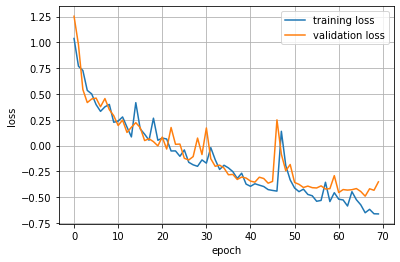

MAAD error : 7.134485 pm 0.160148SEM
log-likelihood : 0.484970 pm 0.025749SEM


{'log_likelihood_mean': 0.4849696457386017,
 'log_likelihood_sem': 0.025748685468719456,
 'maad_loss': 7.134485244750977,
 'maad_loss_sem': 0.16014791016963065,
 'mean_kappa': 79.31316375732422,
 'std_kappa': 74.01744079589844}

In [51]:
# torch.cuda.empty_cache()
# # Initialize the model. Select predict_kappa and loss_type
testing_model = BiternionVGG(predict_kappa=True, loss_type='vm_likelihood')

# Testing and validation of the model
testing_model.train(data_loaders, n_epochs = 70)

# Evaluation of the model
testing_model.evaluation(data_loaders)


### Understanding the code
This code block can be used to plot images from the respective dataset. Use to get an understanding of the code.

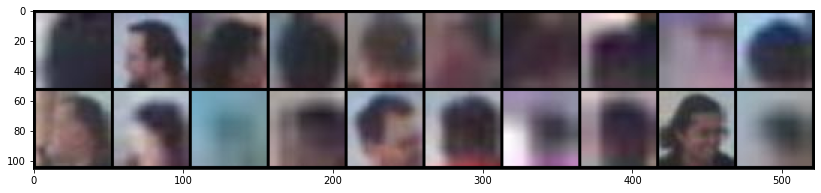

In [52]:
# understanding the data and plotting
import matplotlib.pyplot as plt

sample = next(iter(train_loader))
image, label = sample

grid = torchvision.utils.make_grid(image[0:20], nrow=10 )
plt.figure(figsize=(14,15))
plt.imshow(np.transpose(grid, (1,2,0)))